In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
import numpy as np

from sklearn.feature_selection import SelectFromModel
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
traindf = pd.read_hdf("../data/traindf_clean.hdf")

In [3]:
print(list(traindf.columns))

traindf = traindf.sort_values(by=['srch_id'])

['prop_id', 'srch_id', 'position', 'price_quality', 'click_bool', 'booking_bool', 'price_usd', 'prop_location_score1', 'prop_location_score2', 'avg_price_propid', 'std_avg_price_propid', 'amount_hotels', 'avg_price_propid_after', 'std_avg_price_propid_after', 'price_rank', 'price_correction', 'locationscore2_rank', 'locationscore1_rank', 'importance']


In [4]:
# split label and other variables
x_train, y_train = traindf, traindf["importance"]
positions = pd.DataFrame(y_train).set_index(traindf.srch_id)

# 1 procent van totale data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.97, random_state=42, shuffle=False, stratify = None)
x_traincopy = x_train.copy()
x_train = x_train.drop(columns=["position", "importance", "click_bool", "booking_bool"])
x_test = x_test.drop(columns=["position", "importance", "click_bool", "booking_bool"])

x_train.shape, y_train.shape, x_test.shape

((148750, 15), (148750,), (4809597, 15))

In [5]:
params = {'objective': 'rank:pairwise', 'learning_rate': 0.15,
          'gamma': 1, 'min_child_weight': 1.5,
          'max_depth': 10,  'n_estimators': 400}


# groups equal to length of queries
query_lengths = x_train.groupby('srch_id').size().values
    

In [6]:
model = xgb.sklearn.XGBRanker(**params)
model.fit(x_train, y_train, query_lengths, verbose=True)

XGBRanker(base_score=0.5, booster=None, colsample_bylevel=1, colsample_bynode=1,
          colsample_bytree=1, gamma=1, gpu_id=-1, importance_type='gain',
          interaction_constraints=None, learning_rate=0.15, max_delta_step=0,
          max_depth=10, min_child_weight=1.5, missing=nan,
          monotone_constraints=None, n_estimators=400, n_jobs=0,
          num_parallel_tree=1, objective='rank:pairwise', random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method=None, validate_parameters=False, verbosity=None)

In [7]:
# Make fake column of positions to test score in ndcg scoring function
x_train["position_temp"] = x_train.groupby(['srch_id']).cumcount()+1

In [8]:
# x_train["position"] = y_train
predictions_sorted = []
prop_ids_sorted = []

# x_train = x_train.drop(["position", "pred"], axis=1)

# Sort predictions for each group SEPERATELY
for srchid, group in x_train.groupby('srch_id'):
    
    # Predictions for one search_id
    pred = model.predict(group.drop("position_temp", axis=1))
    
    # Sort all columns (position and prop_id) from this group based on predictions
    predictions = [x for _,x in sorted(zip(pred, group.position_temp), reverse=True)] # TODO: Reverse = False toch? Hoezo werkt dit..
    predictions_sorted.append(predictions)
    
    prop_id = [x for _,x in sorted(zip(pred, group.prop_id), reverse=True)]
    prop_ids_sorted.append(prop_id)
    
# Flatten lists
predictions_sorted = [item for sublist in predictions_sorted for item in sublist]
prop_ids_sorted = [item for sublist in prop_ids_sorted for item in sublist]


In [9]:
x_traincopy["prop_id"] = prop_ids_sorted
x_traincopy["predicted_rank"] = predictions_sorted
final_df = x_traincopy
final_df.head()

,prop_id,srch_id,position,price_quality,click_bool,booking_bool,price_usd,prop_location_score1,prop_location_score2,avg_price_propid,std_avg_price_propid,amount_hotels,avg_price_propid_after,std_avg_price_propid_after,price_rank,price_correction,locationscore2_rank,locationscore1_rank,importance,predicted_rank
20,68914,1,28,40.960000,0,0,122.88,2.71,0.0359,124.563111,406.794296,614.0,96.276998,204.819608,10.0,122.88,17.0,20.5,0,20
11,88218,1,19,33.630000,0,0,100.89,2.20,0.0377,109.728938,365.575410,706.0,84.348571,184.780435,3.0,100.89,18.0,10.0,0,3
18,59526,1,8,28.780000,0,0,115.12,2.77,0.1266,132.457652,413.600487,724.0,101.608290,209.812389,7.5,115.12,27.0,22.5,0,2
15,95166,1,31,50.445000,0,0,100.89,1.79,0.0072,95.804070,285.593936,570.0,72.215896,144.297825,3.0,100.89,7.0,5.0,0,1
6,88096,1,18,43.116667,0,0,129.35,2.20,0.0356,104.384171,9.689352,211.0,104.384171,9.689352,12.0,129.35,16.0,10.0,0,16


In [10]:
# final_df["predicted_rank"] = final_df["position_temp"]
final_df.head()

,prop_id,srch_id,position,price_quality,click_bool,booking_bool,price_usd,prop_location_score1,prop_location_score2,avg_price_propid,std_avg_price_propid,amount_hotels,avg_price_propid_after,std_avg_price_propid_after,price_rank,price_correction,locationscore2_rank,locationscore1_rank,importance,predicted_rank
20,68914,1,28,40.960000,0,0,122.88,2.71,0.0359,124.563111,406.794296,614.0,96.276998,204.819608,10.0,122.88,17.0,20.5,0,20
11,88218,1,19,33.630000,0,0,100.89,2.20,0.0377,109.728938,365.575410,706.0,84.348571,184.780435,3.0,100.89,18.0,10.0,0,3
18,59526,1,8,28.780000,0,0,115.12,2.77,0.1266,132.457652,413.600487,724.0,101.608290,209.812389,7.5,115.12,27.0,22.5,0,2
15,95166,1,31,50.445000,0,0,100.89,1.79,0.0072,95.804070,285.593936,570.0,72.215896,144.297825,3.0,100.89,7.0,5.0,0,1
6,88096,1,18,43.116667,0,0,129.35,2.20,0.0356,104.384171,9.689352,211.0,104.384171,9.689352,12.0,129.35,16.0,10.0,0,16


In [11]:
# final_df.to_pickle("../pickles/XGBoost_test9mei.pkl")

In [12]:
def indiv_search_ndcg_score(true_rank, predicted_rank, booked, clicked):
    # holder for ideal score
    idcg = 0
    
    # holder for our score
    dcg = 0

    # itereer over elk resultaat in de search
    for i in range(len(true_rank)):
        # hotels die geboekt zijn zijn heel belangrijk (5)
        if booked[i] == 1:
            
            # increment ideal score
            if i != 0:
                idcg = idcg + (5 / np.log2(i+1))
            else:
                idcg += 5

            # if predicted well, increment score
            if true_rank[i] == predicted_rank[i]:
                if i != 0:
                    dcg = dcg + (5 / np.log2(i+1))
                else:
                    dcg += 5
                
        # hotels waarop geklikt is zijn een beetje belangrijk (1)
        elif clicked[i] == 1:

            # increment ideal score
            if i != 0:
                idcg = idcg + (1 / np.log2(i+1))
            else:
                idcg += 1
            
            # if predicted well, increment score
            if true_rank[i] == predicted_rank[i]:
                dcg = dcg + (1 / np.log2(i+2))

    if idcg == 0:
        return dcg
    return dcg/idcg

# score function for every search (thus iterate over groupby object)
def dataframe_ndcg_score(solution):
    all_scores = []
    for srchid, group in solution.groupby('srch_id'):

        # true_rank
        true_rank = np.asarray(group['position'])

        # predicted_rank
        predicted_rank = np.asarray(group['predicted_rank'])
        
        # booking_bool
        booked = np.asarray(group['booking_bool'])
        
        # click_bool
        clicked = np.asarray(group['click_bool'])
        all_scores.append(indiv_search_ndcg_score(true_rank, predicted_rank, booked, clicked))
        
    return np.nanmean(all_scores)

In [13]:
print(round(dataframe_ndcg_score(final_df),6) * 100, "%")

6.0781 %


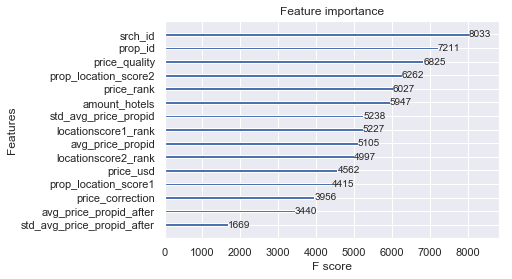

In [14]:
xgb.plot_importance(booster=model )
plt.show()